### How to load the data

This jupyter notebook demonstrates how to access the data of the dataset. To run the notebook you will need to install the following packages:
- pymef (to read MEF3 format)
- pybids (to load the BIDS data structure)


Let's do the imports first

In [151]:
import os

from pymef import MefSession
from bids import BIDSLayout

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.signal import butter, filtfilt


SETTINGS

In [152]:
APPLY_LOW_PASS_FILTER = True
LSTM_READY = True
FEATURE_SET = 2
subject = '004'
run = 2

Now load the BIDS dataset

In [153]:
path_to_dataset = r"C:\MasterThesis\v1.0"  # Please change this value

l = BIDSLayout(path_to_dataset)

Define what data we want to load

In [154]:
filter_dictionary = {'subject': subject,
                     'session': '001',
                     'task': 'FR',
                     'run': run,
                     'suffix': 'ieeg',
                     'extension': 'json'}
json_files = l.get(**filter_dictionary)

# We now we have requested only one file now but multiple files can be processed in a for loop
json_file = json_files[0]
print(json_file)

json_entities = json_file.entities

<BIDSJSONFile filename='C:\MasterThesis\v1.0\sub-004\ses-001\ieeg\sub-004_ses-001_task-FR_run-02_ieeg.json'>


Load information about channels

In [155]:
# Get channels
channel_file = l.get(suffix='channels', extension='tsv',
                     task=json_entities['task'],
                     subject=json_entities['subject'],
                     session=json_entities['session'],
                     run=json_entities['run'])[0]
channel_df = channel_file.get_df()
channel_df = channel_df[channel_df['status'] != 'bad']
channel_df
    

,name,type,units,low_cutoff,high_cutoff,reference,sampling_frequency,status,status_description
0,LAM_01,SEEG,µV,0.1,6000.0,scalp_cpz,32000,good,NaN
2,LAM_03,SEEG,µV,0.1,6000.0,scalp_cpz,32000,good,NaN
3,LAM_04,SEEG,µV,0.1,6000.0,scalp_cpz,32000,good,NaN
4,LAM_05,SEEG,µV,0.1,6000.0,scalp_cpz,32000,good,NaN
5,LAM_06,SEEG,µV,0.1,6000.0,scalp_cpz,32000,good,NaN
...,...,...,...,...,...,...,...,...,...
132,RIGHT_PUPIL_SIZE,PUPIL,px2,NaN,NaN,scalp_cpz,150,good,NaN
133,RIGHT_X_COORD,EYEGAZE,px,NaN,NaN,scalp_cpz,150,good,NaN
134,RIGHT_Y_COORD,EYEGAZE,px,NaN,NaN,scalp_cpz,150,good,NaN
135,SCREEN_X,EYEGAZE,px,NaN,NaN,scalp_cpz,150,good,NaN


Load events

In [156]:
events_file = l.get(suffix='events', extension='tsv',
                    task=json_entities['task'],
                    subject=json_entities['subject'],
                    session=json_entities['session'],
                    run=json_entities['run'])[0]
events_df = events_file.get_df()

# Pull only the processed events (discarding the original events)
events_df = events_df.loc[~events_df['trial_type'].isna(), ['onset', 'sample', 'duration', 'trial_type', 'list']]
events_df = events_df[events_df['trial_type'] == 'ENCODE']
events_df = events_df.reset_index(drop=True)
events_df


,onset,sample,duration,trial_type,list
0,213.724414,6839181,1.483000,ENCODE,1.0
1,216.217632,6918964,1.489812,ENCODE,1.0
2,218.718912,6999005,1.488531,ENCODE,1.0
3,221.212755,7078808,1.494718,ENCODE,1.0
4,223.720192,7159046,1.487249,ENCODE,1.0
...,...,...,...,...,...
175,1765.281885,56489020,1.487062,ENCODE,15.0
176,1767.779728,56568951,1.489187,ENCODE,15.0
177,1770.274977,56648799,1.493968,ENCODE,15.0
178,1772.774851,56728795,1.494093,ENCODE,15.0


Now load the raw data

In [157]:
# Since we are using MEF3 pybids has problems recognizing the extension so we need to modify the json extension
mef_session_path = os.path.splitext(json_file.path)[0]+'.mefd'
print(mef_session_path)
ms = MefSession(mef_session_path, None)
ms.read_ts_channel_basic_info()

C:\MasterThesis\v1.0\sub-004\ses-001\ieeg\sub-004_ses-001_task-FR_run-02_ieeg.mefd


[{'name': 'LAM_01',
  'fsamp': array([32000.]),
  'nsamp': array([61149088], dtype=int64),
  'ufact': array([0.03051851]),
  'unit': array([b'uV'], dtype='|S128'),
  'start_time': array([1554027248092467], dtype=int64),
  'end_time': array([1554029159001450], dtype=int64),
  'channel_description': array([b'SEEG'], dtype='|S2048')},
 {'name': 'LAM_02',
  'fsamp': array([32000.]),
  'nsamp': array([61149088], dtype=int64),
  'ufact': array([0.03051851]),
  'unit': array([b'uV'], dtype='|S128'),
  'start_time': array([1554027248092467], dtype=int64),
  'end_time': array([1554029159001450], dtype=int64),
  'channel_description': array([b'SEEG'], dtype='|S2048')},
 {'name': 'LAM_03',
  'fsamp': array([32000.]),
  'nsamp': array([61149088], dtype=int64),
  'ufact': array([0.03051851]),
  'unit': array([b'uV'], dtype='|S128'),
  'start_time': array([1554027248092467], dtype=int64),
  'end_time': array([1554029159001450], dtype=int64),
  'channel_description': array([b'SEEG'], dtype='|S2048')}

Now load the data from encoding events

In [158]:
channels = ['LEFT_PUPIL_SIZE', 'RIGHT_PUPIL_SIZE']

# Microseconds 1 μs = 10⁻⁶ s
start_time = 1553941347170839+3*1e6  # in microseconds
end_time = 1553942904095135-3*1e6
win_size = 10  # in seconds
stop_time = start_time + int(win_size*1e6)

bi = ms.read_ts_channel_basic_info()

# In this case we are reading MEF records instead of data from events.tsv because we do not have to make time conversions this way
records = ms.read_records()
records_in_win = [x for x in records if start_time < x['time'] < stop_time]
# The code to get corresponding events from the events file
session_metadata = ms.session_md
session_start_utc = session_metadata['session_specific_metadata']['earliest_start_time'][0]
print(f"session_start_utc = {session_start_utc}\nsession_stop_utc = {stop_time}")
events_df['microsecond_onset'] = events_df['onset']*1e6
events_df['uutc'] = (events_df['microsecond_onset'] + session_start_utc).astype('int64')
events_in_win = events_df[(start_time < events_df['uutc'])
                          & (events_df['uutc'] < stop_time)]
events_df.head()

session_start_utc = 1554027248092467
session_stop_utc = 1553941360170839.0


,onset,sample,duration,trial_type,list,microsecond_onset,uutc
0,213.724414,6839181,1.483000,ENCODE,1.0,213724414.0,1554027461816881
1,216.217632,6918964,1.489812,ENCODE,1.0,216217632.0,1554027464310099
2,218.718912,6999005,1.488531,ENCODE,1.0,218718912.0,1554027466811379
3,221.212755,7078808,1.494718,ENCODE,1.0,221212755.0,1554027469305222
4,223.720192,7159046,1.487249,ENCODE,1.0,223720192.0,1554027471812659


In [159]:
# records_in_events = [x for x in records if (0 < (x['time'] - events_df['uutc']) < 150000)]
records_in_events = []
for x in records:
    for e in events_df['uutc']:
        # print(x['time'] - e)
        if 0 == (x['time'] - e):
            records_in_events.append(x)

len(records_in_events)
data_events = []
for e in events_df['uutc']:
    data_events.append(ms.read_ts_channels_uutc(channels, [e - 500000, e + 1000000]))
data_events = np.array(data_events)
data_events.shape

(180, 2, 225)

In [160]:
print(data_events[0])

[[2.66816000e+08 2.66816000e+08 2.63110700e+08 2.72961600e+08
  2.75502199e+08 2.68279999e+08 2.69099200e+08 2.69150000e+08
  2.69150000e+08 2.68974999e+08 2.57644800e+08 2.61739200e+08
  2.54214400e+08 2.54214400e+08 2.54214400e+08 2.52738399e+08
  2.53990099e+08 2.54448000e+08 2.57816000e+08 2.47062500e+08
  2.54660000e+08 2.54660000e+08 2.54660000e+08 2.60737600e+08
  2.64476200e+08 2.58630400e+08 2.48930000e+08 2.49876900e+08
  2.50410000e+08 2.48610500e+08 2.54641000e+08 2.52227300e+08
  2.48148000e+08 2.47254000e+08 2.51084400e+08 2.47880400e+08
  2.47880400e+08 2.42402999e+08 2.53352699e+08 2.42107199e+08
  2.38905600e+08 2.55638400e+08 2.35728500e+08 2.47068400e+08
  2.43651000e+08 2.29170599e+08 2.28486100e+08 2.37880900e+08
  2.36729500e+08 2.36729500e+08 2.36729500e+08 2.35213700e+08
  2.30630399e+08 2.38053200e+08 2.39168400e+08 2.53278900e+08
  2.40099300e+08 2.42505700e+08 2.40389100e+08 2.40099199e+08
  2.39811999e+08 2.39811999e+08 2.38545000e+08 2.35293999e+08
  2.3600

## Artefacts cutout

In [161]:
def check_missing_values(arr):
    """Check if a numpy array has missing values."""
    if np.isnan(arr).any():
        print("The array has missing values.")
        return True
    else:
        return False

In [162]:
for s_idx, sequence in enumerate(data_events):
    for ch_idx, channel in enumerate(sequence):
        missing_values_idx = []
        for sample_idx, sample in enumerate(channel):
            if np.isnan(sample):
                missing_values_idx.append(sample_idx)
        print(missing_values_idx)
        for missing in missing_values_idx[::-1]:
            if missing >= 5:
                for i in range(5):
                    data_events[s_idx][ch_idx][missing-i] = np.nan
            if missing <= 221:
                for i in range(3):
                    data_events[s_idx][ch_idx][missing+i] = np.nan

[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224]
[211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[0, 1, 4, 5, 6, 7]
[0, 1, 4, 5, 6, 7]
[]
[]
[]
[]
[120, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 160, 165]
[119, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 165]
[]
[]
[]
[]
[159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 

## Apply linear interpolation if values are missing

In [163]:
how_many_nan = 0
for s_idx, sequence in enumerate(data_events):
    for ch_idx, channel in enumerate(sequence):
        if check_missing_values(channel):
            how_many_nan += 1
            df = pd.DataFrame({'signal': channel})
            print(f"Apply linear interpolation to fill the missing values [{s_idx}][{ch_idx}]")
            df['signal'] = df['signal'].bfill().ffill().interpolate(method='linear')
            data_events[s_idx][ch_idx] = df['signal'].values.tolist()
            print(data_events[s_idx][ch_idx])
print(how_many_nan)

The array has missing values.
Apply linear interpolation to fill the missing values [10][0]
[2.08749300e+08 2.07260600e+08 2.03813100e+08 2.03526400e+08
 2.06944800e+08 2.17131199e+08 2.14074200e+08 2.10144999e+08
 2.10277500e+08 2.16885900e+08 2.15165499e+08 2.14062400e+08
 2.17319700e+08 2.16705600e+08 2.15579000e+08 2.15579000e+08
 2.15579000e+08 2.15284200e+08 2.15016600e+08 2.13411000e+08
 2.13411000e+08 2.13411000e+08 2.15763000e+08 2.15604000e+08
 2.18743200e+08 2.07457200e+08 2.07438000e+08 2.07438000e+08
 2.07438000e+08 2.07438000e+08 2.07438000e+08 2.04748800e+08
 2.21558400e+08 2.12444000e+08 2.12459000e+08 2.12612399e+08
 2.23977900e+08 2.09457000e+08 2.09457000e+08 2.10618200e+08
 2.04576900e+08 2.04576900e+08 2.05043199e+08 1.95674500e+08
 1.95803999e+08 1.95825600e+08 1.95825600e+08 1.95674500e+08
 1.92298400e+08 1.96299999e+08 1.98640000e+08 1.97662800e+08
 1.97273700e+08 2.03250000e+08 1.97638000e+08 1.96216800e+08
 1.96216800e+08 1.93009500e+08 1.93009500e+08 1.930095

## Connect windows to continuous signal across channels

In [164]:
channel_1_raw = []
channel_2_raw = []
for s_idx, sequence in enumerate(data_events):
    for sample in data_events[s_idx][0]:
        channel_1_raw.append(sample)
    for sample in data_events[s_idx][1]:
        channel_2_raw.append(sample)
channel_1_raw = np.array(channel_1_raw)
channel_2_raw = np.array(channel_2_raw)
channel_1_raw.shape

(40500,)

### Apply z-score normalization

In [165]:
mean = np.mean(channel_1_raw)
std = np.std(channel_1_raw)
data_normalized = (channel_1_raw - mean) / std
channel_1_raw = data_normalized

mean = np.mean(channel_2_raw)
std = np.std(channel_2_raw)
data_normalized = (channel_2_raw - mean) / std
channel_2_raw = data_normalized

### Split again into windows

In [166]:
def split_list(lst, n):
    """Split the list, lst, into chunks of size n."""
    return [lst[i:i + n] for i in range(0, len(lst), n)]

In [167]:
chunks_1 = split_list(channel_1_raw, 225)
chunks_2 = split_list(channel_2_raw, 225)
print(len(chunks_1))

180


In [168]:
for s_idx, sequence in enumerate(data_events):
    for ch_idx, channel in enumerate(sequence):
        if ch_idx == 0:
            data_events[s_idx][ch_idx] = chunks_1[s_idx]
        elif ch_idx == 1:
            data_events[s_idx][ch_idx] = chunks_2[s_idx]
data_events = np.array(data_events)
print(data_events.shape)

(180, 2, 225)


In [169]:
print(data_events[0][0][0])

1.0062764010926573


## Plot the window

In [170]:
def plot_channels(data):
    # assuming 'data' is your list
    data = np.array(data)  # convert list to numpy array
    print(data.shape)
    time = np.arange(0, data.shape[1])  # creating a time vector

    # plotting the data
    plt.figure(figsize=(10,6))  # creating a new figure with specified size
    print(data[0])
    # plot for channel 1
    plt.subplot(2, 1, 1)  # creating the first subplot in a 2x1 grid
    plt.plot(time, data[0], color='blue')  # plotting the data for the first channel
    plt.title('Channel 1')  # setting the title of the first subplot
    plt.xlabel('Time')  # setting the x-label
    plt.ylabel('Amplitude')  # setting the y-label

    # plot for channel 2
    plt.subplot(2, 1, 2)  # creating the second subplot in a 2x1 grid
    plt.plot(time, data[1], color='red')  # plotting the data for the second channel
    plt.title('Channel 2')  # setting the title of the second subplot
    plt.xlabel('Time')  # setting the x-label
    plt.ylabel('Amplitude')  # setting the y-label

    plt.tight_layout()  # adjusting the layout so everything fits
    plt.show()  # displaying the figure

(2, 225)
[1.0062764  1.0062764  0.94179954 1.11321754 1.15742714 1.03175182
 1.04600694 1.04689092 1.04689092 1.04384569 0.84668604 0.91793372
 0.78699278 0.78699278 0.78699278 0.76130851 0.78308966 0.79105771
 0.84966513 0.66254076 0.79474678 0.79474678 0.79474678 0.90050463
 0.96556095 0.86383671 0.6950376  0.71151485 0.72079146 0.6894779
 0.79441615 0.75241475 0.68142982 0.6658731  0.73252686 0.67677325
 0.67677325 0.58145961 0.7719981  0.57631232 0.52060049 0.81177216
 0.46531497 0.66264343 0.60317639 0.35119928 0.33928814 0.50276943
 0.48273362 0.48273362 0.48273362 0.45635681 0.37660163 0.50576766
 0.52517354 0.77071391 0.54137236 0.58324674 0.54641525 0.54137061
 0.53637297 0.53637297 0.5143256  0.45775411 0.47009161 0.46969139
 0.58634936 0.48775735 0.47067282 0.66076062 0.4717656  0.41011644
 0.45937592 0.5747149  0.53222453 0.49234782 0.52597746 0.67895537
 0.62710137 0.61366239 0.60562997 0.68866351 0.60703947 0.65775018
 0.72235757 0.49850786 0.52516136 0.52516136 0.6992521

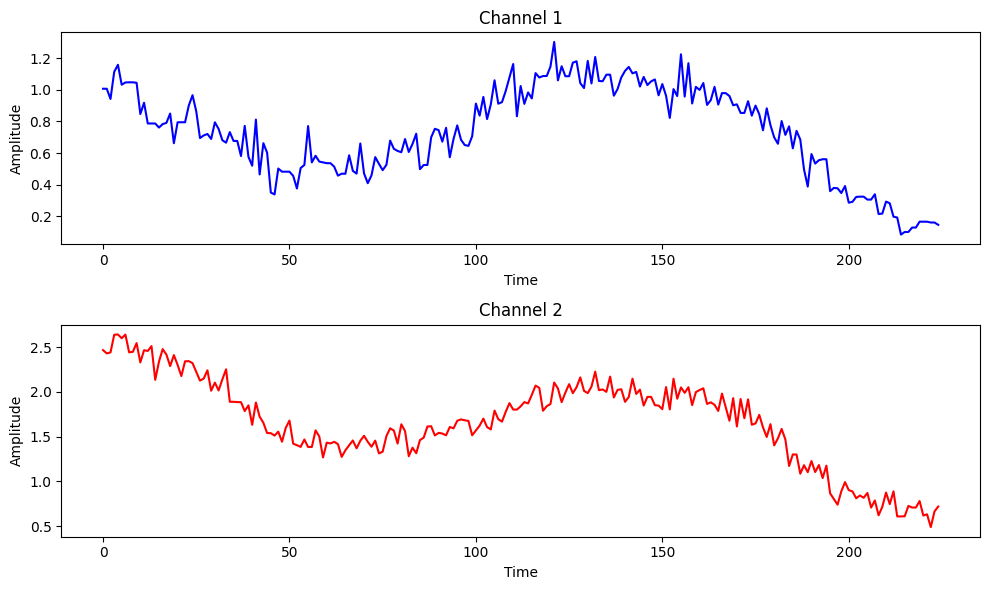

In [171]:
plot_channels(data_events[0])

## Define and apply butterworth filter

In [172]:
def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = filtfilt(b, a, data)
    return y

# Parameters
order = 3
fs = 150.0       # sample rate, Hz
cutoff = 30.0    # desired cutoff frequency of the filter, Hz


In [173]:
for s_idx, sequence in enumerate(data_events):
    for ch_idx, channel in enumerate(sequence):
        y = butter_lowpass_filter(channel, cutoff, fs, order)
        data_events[s_idx][ch_idx] = y

(2, 225)
[1.00628027 0.99056127 1.01712777 1.07094173 1.09923264 1.08327375
 1.05678291 1.04726373 1.03692434 0.99644686 0.92879542 0.86115212
 0.81208039 0.78322381 0.77158852 0.7761078  0.79061818 0.79719129
 0.78135382 0.75476895 0.74702546 0.77768541 0.84206239 0.90557574
 0.91547301 0.85058535 0.75492192 0.69563259 0.69761168 0.73238376
 0.75412556 0.74074813 0.7098363  0.69095325 0.68734998 0.68256924
 0.67202145 0.66058261 0.64446647 0.62488972 0.61835865 0.62968821
 0.63573587 0.60285209 0.51939335 0.42646808 0.39177494 0.43041914
 0.48720656 0.50413892 0.47218629 0.42768503 0.42381307 0.48725355
 0.58314136 0.64065376 0.62717928 0.57755008 0.54295177 0.53755016
 0.5411031  0.53025659 0.50174191 0.47511842 0.47190705 0.490849
 0.51378362 0.53237428 0.54471829 0.53454449 0.49604853 0.46510763
 0.47579159 0.50770425 0.52404824 0.53310597 0.56451367 0.61000576
 0.63456539 0.63077028 0.62442855 0.63675283 0.66187653 0.66944523
 0.62987714 0.55853065 0.5204557  0.56358252 0.66068056

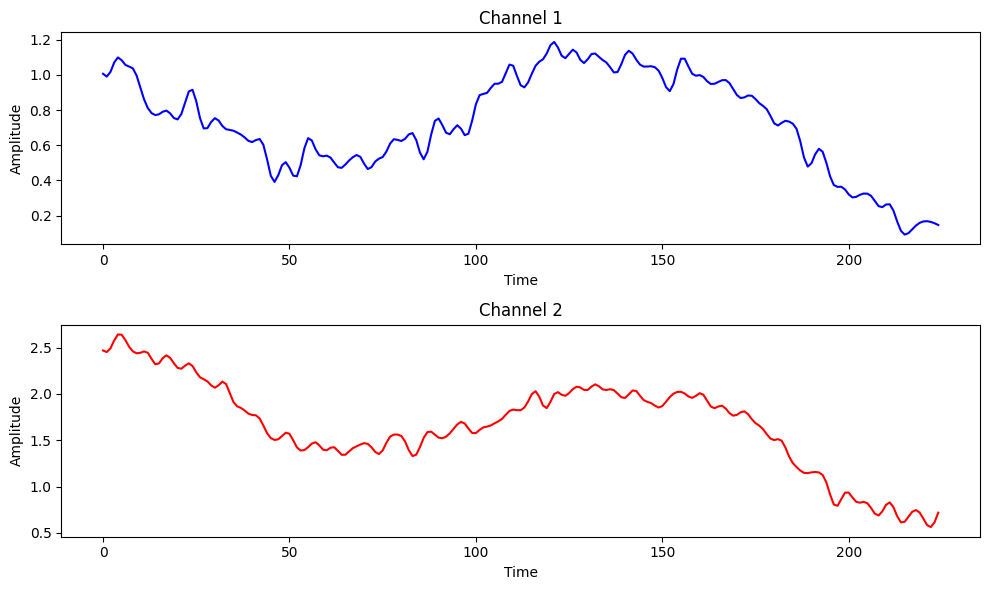

In [174]:
plot_channels(data_events[0])

## Feature extraction

### Feature set 1
https://www.hindawi.com/journals/cin/2020/2909267/

In [175]:
import scipy.fft


if FEATURE_SET == 1:
    for s_idx, sequence in enumerate(data_events):
        for ch_idx, channel in enumerate(sequence):
            eeg_data = channel
           # Calculate Mean of the signal as a feature
            mean = np.mean(eeg_data)

            # Calculate Variance of the signal as a feature
            variance = np.var(eeg_data)

            # Calculate Standard Deviation of the signal as a feature
            std_dev = np.std(eeg_data)

            # Use Fast Fourier Transform to get the power spectrum of the signal
            power_spectrum = np.abs(scipy.fft.fft(eeg_data))**2

            # Frequency values for plotting the spectrum - assuming a sampling rate (fs) of 128 Hz
            freqs = scipy.fft.fftfreq(len(eeg_data), 1 / 128)

            # Let's use the mean power in specific frequency bands as features
            delta_power = np.mean(power_spectrum[(freqs >= 0.5) & (freqs <= 4)])
            theta_power = np.mean(power_spectrum[(freqs > 4) & (freqs <= 8)])
            alpha_power = np.mean(power_spectrum[(freqs > 8) & (freqs <= 12)])
            beta_power = np.mean(power_spectrum[(freqs > 12) & (freqs <= 30)])

            # Gather all features into a list
            features = [mean, variance, std_dev, delta_power, theta_power, alpha_power, beta_power]

            print("Extracted features:", features)
            data_events[s_idx][ch_idx] = features
    print(len(data_events))
    print(len(data_events[0]))
    print(len(data_events[0][0]))

### Feature set 2 - 6 features
https://www.mdpi.com/2227-9032/11/3/322

In [176]:
from scipy.stats import skew, kurtosis, variation


if FEATURE_SET == 2 and not LSTM_READY:
    data_events = data_events.tolist()
    # Assuming 'eeg_data' is a NumPy array containing your EEG data.
    for s_idx, sequence in enumerate(data_events):
        for ch_idx, channel in enumerate(sequence):
            eeg_data = channel
           # Assuming 'eeg_data' is a NumPy array containing your EEG data for one channel

            mean = np.mean(eeg_data)
            q1 = np.percentile(eeg_data, 25)
            q2 = np.percentile(eeg_data, 50)
            q3 = np.percentile(eeg_data, 75)
            min_signal = np.min(eeg_data)
            max_signal = np.max(eeg_data)
            # variance = variation(eeg_data)
            # skewness = skew(eeg_data)

            features = [mean, q1, q2, q3, min_signal, max_signal]

            # print("Extracted features:", features)
            data_events[s_idx][ch_idx] = features
    data_events = np.array(data_events)
    print(data_events.shape)

### Feature set 3 - 4 features
https://www.hindawi.com/journals/cin/2020/2909267/

In [177]:

if FEATURE_SET == 3:
    data_events = data_events.tolist()
    # Assuming 'eeg_data' is a NumPy array containing your EEG data.
    for s_idx, sequence in enumerate(data_events):
        for ch_idx, channel in enumerate(sequence):
            eeg_data = channel
           # Assuming 'eeg_data' is a NumPy array containing your EEG data for one channel

            mean = np.mean(eeg_data)
            variance = variation(eeg_data)
            skewness = skew(eeg_data)
            # kurtosis = kurtosis(eeg_data)

            features = [mean, variance, skewness]

            print("Extracted features:", features)
            data_events[s_idx][ch_idx] = features
    data_events = np.array(data_events)
    print(data_events.shape)

## Reshape to dataframe

In [178]:
arr = np.array(data_events)

    # Reshape the array to the required shape (180, 450)
arr_reshaped = arr.reshape(180, -1)  # -1 means calculate the size of this dimension

df = pd.DataFrame(arr_reshaped)

    # Now df is a DataFrame with shape (180, 450)
print(df.shape)

(180, 450)


In [179]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,440,441,442,443,444,445,446,447,448,449
0,1.006280,0.990561,1.017128,1.070942,1.099233,1.083274,1.056783,1.047264,1.036924,0.996447,...,0.620160,0.674400,0.727243,0.746794,0.720653,0.654873,0.585067,0.562754,0.614228,0.718476
1,0.980315,1.038073,1.075711,1.091539,1.095308,1.096024,1.103126,1.122749,1.145988,1.159161,...,2.991100,3.002025,3.005059,3.002042,3.008022,3.031986,3.048799,3.030136,2.993794,2.968772
2,0.974923,1.078741,1.145508,1.162571,1.157595,1.163074,1.166642,1.134871,1.073142,1.019781,...,1.250379,1.283690,1.289739,1.262231,1.222101,1.202103,1.206724,1.196450,1.127210,1.002628
3,-0.793163,-0.792799,-0.792555,-0.793273,-0.795662,-0.798948,-0.801403,-0.802240,-0.801982,-0.801110,...,0.700044,0.648221,0.630577,0.671433,0.732297,0.744029,0.674098,0.579328,0.559621,0.635417
4,-0.722105,-0.724387,-0.741381,-0.768800,-0.789767,-0.795675,-0.792464,-0.789146,-0.788692,-0.789814,...,0.059212,0.061463,0.049327,0.033570,0.026358,0.012644,-0.018046,-0.042961,-0.032404,0.011899


In [180]:
df.to_csv(rf'C:\MasterThesis\v1.0\sub-{subject}\ses-001\{subject}_{run}_pupil_dataset.csv', index=False)